# Policy gradient algrorithm with BigDL

In [1]:
import random
import gym
import numpy as np
from collections import deque
import matplotlib.pyplot as plt

from bigdl.dataset.transformer import Sample
from bigdl.nn.layer import *
from bigdl.util.common import *
from bigdl.optim.optimizer import *
from bigdl.nn.criterion import *

from rl.criterion import *
import to_rdd

from keras import models
from keras.layers import Dense
from keras import optimizers

init_engine()

Using TensorFlow backend.


In [25]:
class PGAgent:
    def __init__(self, state_size, action_size, batch_size=32, gamma=0.95,learning_rate=0.01):
        self.state_size = state_size
        self.action_size = action_size
        self.memory = deque(maxlen=2000)
        self.gamma = gamma  # discount rate
        self.learning_rate = learning_rate
        self.model = self._build_model()
        self.value_func = self._build_vf()
        self.memory = deque(maxlen=2000)
        self.batch_size = batch_size

    def _build_model(self):
        model = Sequential()

        model.add(Linear(self.state_size, 24))
        model.add(ReLU())

        model.add(Linear(24, 24))
        model.add(ReLU())

        model.add(Linear(24, 2))
        model.add(SoftMax())
        return model
    
    def _build_vf(self):
        model = models.Sequential()
        model.add(Dense(24, input_dim=self.state_size, activation='relu'))
        model.add(Dense(24, activation='relu'))
        model.add(Dense(self.action_size, activation='linear'))
        model.compile(loss='mse',
                      optimizer=optimizers.Adam(lr=0.001))
        return model
    
    def train_val_func(self):
        if len(self.memory) < self.batch_size:
            pass
        else:
            minibatch = random.sample(self.memory, self.batch_size)
            for state, action, reward, next_state, done in minibatch:
                target = reward
                if not done:
                    target = (reward + self.gamma *
                              np.amax(self.value_func.predict(np.reshape(next_state, [1, state_size]))[0]))
                target_f = self.value_func.predict(np.reshape(next_state, [1, state_size]))
                target_f[0][action] = target
                self.value_func.fit(np.reshape(state, [1, state_size]), target_f, epochs=1, verbose=0)


    def act(self, state):
        result = self.model.forward(state)
        return np.random.choice([0,1],p=result)

In [26]:
def play_game(agent, render=False):
    state = env.reset()
    memory = np.array([0,0,0,0])
    actions = np.array([])
    rewards = np.array([])
    for time in range(500):
        if render:
            env.render()
        memory = np.vstack((memory, state))
        action = agent.act(state)
        actions = np.append(actions, action)
        next_state, reward, done, _ = env.step(action)
        if done:
            reward = -10
        agent.memory.append((state, action, reward, next_state, done))
        if time==498 and not done:
            reward +=1 + agent.gamma*np.amax(agent.value_func.predict(np.reshape(next_state, [1, 4])))
        rewards = np.append(rewards, reward)
        state = next_state
        if done or time == 498:
            break
    return memory[1:], actions, rewards, time

In [27]:
def running_reward(actions, rewards, st_values, gamma):
    result = []
    run_rew = 0
    for action, reward, st_value in list(zip(actions, rewards, st_values))[::-1]:
        run_rew = run_rew*gamma + reward
        result.append([action+1, (run_rew - st_value)])
    return np.vstack(result[::-1])

In [28]:
def get_values(agent, states):
    result = []
    for state in states:
        values = agent.value_func.predict(np.reshape(state, [1, agent.state_size]))[0]
        prediction = agent.model.forward(state)
        result.append(values[0]*prediction[0]+values[1]*prediction[1])
    return result

In [29]:
def play_n_games(agent, n=20):
    X_batch = np.array([0,0,0,0])
    y_batch = np.array([0,0])
    results = []
    for i in range(n):
        a, b, c, d = play_game(agent)
        X_batch = np.vstack((X_batch, a))
        st_values = get_values(agent, a)
        y_batch = np.vstack((y_batch, running_reward(b, c, st_values, agent.gamma)))
        agent.train_val_func()
        results.append(d)
    return X_batch[1:], y_batch[1:], results

In [31]:
env = gym.make('CartPole-v1')
sc = SparkContext.getOrCreate(create_spark_conf())
state_size = env.observation_space.shape[0]
action_size = env.action_space.n
agent = PGAgent(state_size, action_size, learning_rate=1e-2)

[2017-12-21 10:32:16,113] Making new env: CartPole-v1


creating: createSequential
creating: createLinear
creating: createReLU
creating: createLinear
creating: createReLU
creating: createLinear
creating: createSoftMax


In [32]:
%%time
results = []
minimums = []
maximums = []
t=1
while True:
    X_batch, y_batch, result = play_n_games(agent, n = 10)
    print(t, np.mean(result), np.var(result), result)
    results.append(np.mean(result))
    minimums.append(np.min(result))
    maximums.append(np.max(result))
    if result == 498:
        break
    rdd_sample = to_rdd.to_RDD(X_batch, y_batch, sc)
    batch_size = X_batch.shape[0] - X_batch.shape[0]%4
    optimizer = Optimizer(model=agent.model,
                                  training_rdd=rdd_sample,
                                  criterion=PGCriterion(),
                                  optim_method=SGD(learningrate=agent.learning_rate),
                                  end_trigger=MaxIteration(1),
                                  batch_size=batch_size)
    agent.model = optimizer.optimize()
    t += 1

1 15.4 29.84 [10, 20, 9, 24, 20, 20, 10, 18, 8, 15]
creating: createPGCriterion
creating: createDefault
creating: createSGD
creating: createMaxIteration
creating: createOptimizer
2 23.1 107.69 [28, 18, 24, 30, 46, 17, 10, 10, 18, 30]
creating: createPGCriterion
creating: createDefault
creating: createSGD
creating: createMaxIteration
creating: createOptimizer
3 15.8 34.16 [19, 13, 8, 9, 23, 14, 13, 28, 14, 17]
creating: createPGCriterion
creating: createDefault
creating: createSGD
creating: createMaxIteration
creating: createOptimizer
4 23.4 174.64 [58, 13, 18, 25, 31, 19, 12, 12, 17, 29]
creating: createPGCriterion
creating: createDefault
creating: createSGD
creating: createMaxIteration
creating: createOptimizer
5 25.3 174.81 [35, 15, 32, 36, 16, 50, 14, 11, 35, 9]
creating: createPGCriterion
creating: createDefault
creating: createSGD
creating: createMaxIteration
creating: createOptimizer
6 17.4 41.24 [24, 13, 14, 10, 16, 17, 11, 15, 32, 22]
creating: createPGCriterion
creating: creat

KeyboardInterrupt: 

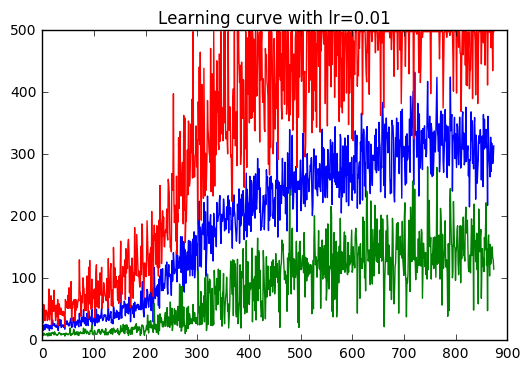

In [33]:
plt.plot(results)
plt.plot(minimums)
plt.plot(maximums)
plt.title('Learning curve with lr='+str(agent.learning_rate))
#plt.savefig('PGAC_BigDL_KerasVF_rew:-10_wo_Clip')
plt.show()